In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Acea Smart water analytics: predicting water availability to handle consumption 

The aim of this notebook is to develop a model to forececast the water level in a waterbody (water spring, lake, river, or aquifer) to handle consumption. The aim is to help Acea, one of the leading Italian multiutility operators, to preserve the health of each managed waterbody in order to manage in the most efficient way water availability. 


## **Data**

There are four different waterbodies for which to predict water availability:
* Acquifers (Auser, Doganella, Petrignano and Luco): target variable "Depth to groundwater"
* Water spring (Aminata, Madonna di Canneto and Lupa): target variable "Flow rate"
* Lake (Bilancino): target variable "Hydrometry (Lake level), Flow Rate 
* River (Arno): target variable "Hydrometry (River level)"

Each waterbody is represented from a different dataset and differs from the others. Each waterbody is also unique: has different features and different variables can influence water availability over time so we need to predict not only what are the most important variables but also which is the most correct time horizon with which to make predictions.

Let's dive into the model!

## **Waterbodies forecasting as a supervised machine learning model: a regression model**

In [ ]:
#libraries to transform and plot data
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
pd.set_option('display.max_columns',500)
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
#libraries to preprocess data, create the model and evaluate the performance of the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import itertools
#library to do some statistics on data
from scipy import stats
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 500)

In [ ]:
Acq_Auser = pd.read_csv(r'../input/acea-water-prediction/Aquifer_Auser.csv')
Acq_Doganella = pd.read_csv(r'../input/acea-water-prediction/Aquifer_Doganella.csv')
Acq_Luco =  pd.read_csv(r'../input/acea-water-prediction/Aquifer_Luco.csv')
Acq_Petrignano = pd.read_csv(r'../input/acea-water-prediction/Aquifer_Petrignano.csv')
River_Arno = pd.read_csv(r'../input/acea-water-prediction/River_Arno.csv')
Lake_Bilancino = pd.read_csv(r'../input/acea-water-prediction/Lake_Bilancino.csv')
Ws_Amiata = pd.read_csv(r'../input/acea-water-prediction/Water_Spring_Amiata.csv')
Ws_Lupa = pd.read_csv(r'../input/acea-water-prediction/Water_Spring_Lupa.csv')
Ws_Madonna_di_Canneto = pd.read_csv(r'../input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv')
print("Dati importati")

The model is based upon the following 8 classes:

* **DataPreparation**: this class is used to prepare data before features engineering. This class takes the raw data and the target of each waterbody as input and return a new dataframe without null values and with "Date" field as index. Raw data has many null values especially in the first occurrences of each dataframe so for each target variable it's calculated what's the index of the last null occurrence. This index it's used to slice the dataframe. As imputer for null values it's used KNNImputer. The reason it's that I want to impute missing values according to the values near the missing ones. As parameter of the imputer it's used "distance" as weights since points near the missing ones are more important than point at a greater distance
* **FeatureEngineering**: this class is used to generate new features, for resampling and for shifting the target variables. This class takes target variable, shift period (with 1 as default) and  resampling frequency (with 'W' week as default) as input and return a dataframe with new features and the target variable shifted. The forecast period and level of aggregation for which make predictions are not pre-defined but are input parameters of the model. As new features are calculated "Day_rainy" and "Day_not_rainy" respectively as the numbers of rainy and not rainy days over the resampled period. New variables are also created by differencing features variables in the range of shifting period.
* **EDA**: this class is used for Exploratory Data Analysis of target variables. There is only one method (plot_target) used to plot target variables and correlations between variables after features engineering.
* **TrainTestSplit**: this class is used to split data in training and testing data. Split ratio between train and test is a model input (default value = 0.8)
* **Model**: this class implements the predictive model. Taking train and test data as input three different dataframes and a list with best parameters for the model are produced as output. The three dataframes are predictions, residuals and importances_df with the most important variables for the model. As model a RandomForestRegressor is used. Before sending the data to the predictive model a RobustScaler is used as preprocessing. It's used a RobustScaler to deal in a better way the outliers. Everything is encapsulated inside a RandomizedSearchCV which takes the pipe as input and enable the model hyperparameters tuning. For each steps of the modelling best estimator it's taken and for this estimator predictions, residuals and features importances are calculated 
* **ModelEvaluation**: this class is used to scoring the model by calculation mae and mse for each combinations of frequency and shift_period. 
* **PlotResults**: this class is used to plot some evidences about the data predicted. In particular there is a lineplot with data predicted and actual data, a regression plot and a residual plot with the aim to see if residuals have some trends. There is also a method (plot_importances) to plot the most important variables for the model at the level of single variables and cumulated variables.
* **Statistics**:this class is used to return some statistics about data modeled. As input takes the residual dataframe and some indicators such as Shapiro,Mean,Variance,Skewness,Kurtosis,Standard_deviation and Standard_error_mean are calculated.The goodness of the model is evaluated by looking at the residuals graph. In the method plot_stat() a probabily plot an histogram plot and a boxplot are calculated.Shapiro - Wilk test tests the null hypothesis that the data was drawn from a normal distribution. Alpha is 0.05. If p-value is greater than alpha we fail to reject null hypothesys and residuals are normally distribuited wheras if p value is less than alpha we reject null hypothesis and data are not normally distribuited.Skew indicates the symmetry or asymmetry of a distribuition in particular how much a distribution is push left or right.Kurtosys is an indicator of how much of the distribution is on the tail.The goodness of the model is evaluated by looking at the residuals graph. In the method plot_stat() a probabily plot an histogram plot and a boxplot are calculated.



In [ ]:
class DataPreparation(BaseEstimator, TransformerMixin):
    """
    This class is used to prepare data before Features engineering. It return a dataframe 
    without null values and with Date field as index. KNNImputer is used to impute
    null values
    """
    def __init__(self, target):
        self.target = target
        
    def fit(self, X, y = None):
        pass
    
    def transform(self, X):
        Xt = X.copy()
        target = [col for col in Xt.columns if col.startswith(self.target)]
        features = [col for col in Xt.columns if col not in self.target]
        max_na_target_variable =[]
        for col in target:
            max_na_target_variable.append(Xt[col].notnull().idxmax())
            df_temp = Xt.iloc[max(max_na_target_variable)+1:,:]
        df_temp['Date'] = pd.to_datetime(df_temp['Date'],dayfirst = True, format = '%d/%m/%Y')
        df_temp.set_index('Date', inplace = True)
        imputer = KNNImputer(n_neighbors=15, weights="distance")
        imputed = imputer.fit_transform(df_temp)
        df_imputed = pd.DataFrame(imputed,index = df_temp.index, columns = df_temp.columns)
        return df_imputed

    
    
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self,target, shift_period = 1, resampled_freq = 'W'):
        self.target = target
        self.shift_period = shift_period
        self.resampled_freq = resampled_freq
        
    def fit(self, X, y = None):
        pass
    
    def transform(self,X):
        Xt = X.copy()
        rainfall_columns = [col for col in Xt.columns if col.startswith('Rain')]
        for col in rainfall_columns:
            Xt[f'Day_rainy_{col}'] = Xt[col].apply(lambda x : 1 if x > 0 else 0)
            Xt[f'Day_not_rainy_{col}'] = Xt[col].apply(lambda x : 1 if x == 0 else 0 )
        aggregation_dict  = {}
        for col in Xt.columns:
            if col.startswith(('Depth', 'Temp','Volu','Hydrom', 'Flow','Lake')):
                aggregation_dict[col] = 'mean'
            elif col.startswith(('Rain','Day')):
                aggregation_dict[col] = 'sum'
            else:
                aggregation_dict[col] = 'mean'
        for col in Xt.columns:
            if col.startswith('Flow'):
                Xt[col] = Xt[col].abs()
        Xt = Xt.resample(self.resampled_freq).agg(aggregation_dict)
        Xt['Month'] = Xt.index.month
        Xt['Year'] = Xt.index.year
        Xt['Quarter'] = Xt.index.quarter
        Xt['Season'] = (Xt.index.month) % 12 // 3 +1
        Xt['Total_days_rainy'] = 0
        for col in Xt.columns:
            if col.startswith('Rain'):
                Xt['Total_days_rainy'] = Xt['Total_days_rainy'] + Xt[col]
        targets = [col for col in Xt.columns if col.startswith(self.target)]
        features = [col for col in Xt.columns if col not in targets]
        for col in features:
            for i in range(1,self.shift_period):
                Xt[f'Differenced_{col}_by_{i}'] = Xt[col].diff(periods = i)
            Xt[col] = Xt[col].shift(self.shift_period)
        Xt.dropna(axis = 0, inplace = True)
        return Xt
            

In [ ]:
class EDA():
    def __init__(self, df, target,df_name, width=20, hight=10):
        self.df = df
        self.target = target
        self.width = width
        self.hight = hight
        self.df_name = df_name
    def plot_target(self):
        target_list = [col for col in self.df.columns if col.startswith(self.target)]
        fig, axes = plt.subplots(nrows = 1, ncols = 2,squeeze = False, figsize = (self.width, self.hight))
        for i in range(len(target_list)):
            sns.lineplot(x =self.df.index, y =self.df[target_list[i]] ,ax = axes[0][0], label=target_list[i])
            axes[0][0].set_title(f"Target variables for {self.df_name} ")
        sns.heatmap(self.df.corr(), ax = axes[0][1])
        axes[0][1].set_title(f"Correltation plot for {self.df_name}  ")
        plt.tight_layout()

In [ ]:
class TrainTestSplit:
    """
    This class is used to split data in train and test. Input data is split ratio and as output are 
    returned four dataframes: X_train, y_train, X_test, y_test
    """
    def __init__(self,df,target,split_ratio = 0.8):
        self.df = df
        self.split_ratio = split_ratio
        self.target = target
    def split(self):
        temp_df = (self.df).copy()
        target_list = [col for col in temp_df.columns if col.startswith(self.target)]
        features = [col for col in temp_df.columns if col not in target_list]
        X = temp_df[features]
        y = temp_df[target_list]
        train_size = math.ceil((temp_df.shape[0])*0.8)
        X_train = X.iloc[:train_size , :]
        y_train = y.iloc[:train_size, :] 
        X_test = X.iloc[train_size:,:]
        y_test = y.iloc[train_size:,:]
        return X_train, y_train, X_test, y_test

In [ ]:
class Model():
    """
    This is the class that model the data. A pipe is created to model data. Pipe is encapsulated in a
    RandomizedSearchCV to have the flexibility to search for the best parameters both for scaler and RandoForestRegressor.
    As output data predicted, dataframe with residuals, dataframe with importances and best parameters for the model.
    """
    def __init__(self,X_train, y_train,X_test, y_test):
        self.X_train =X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    def model(self):
        pipe = Pipeline([('scaler', RobustScaler()),('rfr',RandomForestRegressor(random_state = 0))])
        param_grid = {'rfr__criterion': ['mse','mae'], 'rfr__max_features':['auto','log2'],
                     'rfr__n_estimators':[10,20,30,40,50], 'rfr__min_samples_split':[2,4,8]}
        gs = RandomizedSearchCV(estimator = pipe,param_distributions =  param_grid,n_iter=20,n_jobs=2,verbose = 0, random_state=0 )
        search = gs.fit(X_train, y_train)
        best_params = search.best_estimator_.named_steps['rfr'].get_params()
        importances = search.best_estimator_.named_steps['rfr'].feature_importances_
        importances_df = pd.DataFrame(data = importances, index = X_train.columns, columns = ['Importance'])
        importances_df.sort_values('Importance',ascending = False, inplace = True)
        importances_df['Importance_cumulated'] = importances_df['Importance'].cumsum()  
        predicted = pd.DataFrame(gs.predict(X_test), columns = (y_test.columns+'_predicted'), index = X_test.index)
        residuals = y_test-predicted.values
        for col in residuals:
            residuals.rename(columns ={col: col+'_res'}, inplace = True)
        return predicted, residuals, importances_df, best_params

In [ ]:
class ModelEvaluation():
    """
    This class is used to evaluate the trained model. As input test data, data predicted, shift_period of variables,
    frequency used to resample data and best params of trained model. As output 'Mean absolute error' and 'Mean squared error' are calculated
    """
    def __init__(self, X_test, y_test, df_name,frequency, shift_period,df_predicted, best_params):
        self.X_test = X_test
        self.y_test = y_test
        self.df_name = df_name
        self.frequency = frequency
        self.shift_period =shift_period
        self.df_predicted = df_predicted
        self.best_params = best_params
    def score_model(self):
        mse = mean_squared_error(self.y_test, self.df_predicted)
        mae = mean_absolute_error(self.y_test, self.df_predicted)
        temp_dict = {'Data': [self.df_name], 'Frequency': [self.frequency], 'Shift period': [self.shift_period],  'Mean squared error': [mse], 
                     'Mean absolute error': [mae],'Best parameters':[self.best_params]}
        model_eval  = pd.DataFrame(data = temp_dict)
        return model_eval

In [ ]:
class PlotResults():
    """
    This class is used to plot results of the model and plot importances
    """
    def __init__(self, df_predicted, df_test, df_residual, df_importances):
        self.df_predicted = df_predicted
        self.df_test = df_test
        self.df_residual = df_residual
        self.df_importances = df_importances
    def plot_result(self,figure_width=18,figure_height =30):
        pred_test = list(zip(self.df_predicted.columns, self.df_test.columns, self.df_residual.columns))
        df_temp = self.df_predicted.merge(self.df_test, left_index = True, right_index = True)
        fig, axes = plt.subplots(nrows = len(pred_test), ncols = 3, squeeze = False ,figsize = (figure_width,figure_height))
        for i in range(len(pred_test)):
            sns.lineplot(x =df_temp.index, y =df_temp[pred_test[i][0]] ,ax = axes[i][0], color = 'red' ,label=pred_test[i][0])
            axes[i][0].set_title(f"Predicted vs actual for variable {pred_test[i][0]}")
            sns.lineplot(x =df_temp.index, y = df_temp[pred_test[i][1]],ax = axes[i][0], color = 'blue' ,label=pred_test[i][1])
            sns.regplot(x= pred_test[i][0], y=pred_test[i][1], data=df_temp,ax = axes[i][1] ) 
            axes[i][1].set_title(f"Regression plot for variable {pred_test[i][1]}")
            sns.scatterplot(x=df_temp[pred_test[i][0]] , y=self.df_residual[pred_test[i][2]],ax = axes[i][2])
            axes[i][2].set_title(f"Residual plot for variable {pred_test[i][2]}")
            plt.tight_layout()
    def plot_importances(self, n_var_to_display,figure_width=12,figure_height =9):
        fig,ax = plt.subplots( ncols = 2, figsize =(figure_width,figure_height),squeeze= True)
        sns.barplot(x = self.df_importances[:n_var_to_display]['Importance'],y=self.df_importances[:n_var_to_display].index,orient = 'h', ax = ax[0])
        ax[0].set_title(f"Features importance (first {n_var_to_display} variables)")
        sns.barplot(x=self.df_importances.index[:n_var_to_display], y = self.df_importances['Importance_cumulated'][:n_var_to_display],ax = ax[1])
        ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
        ax[1].set_title(f"Cumulated importance (first {n_var_to_display} variables)")
        plt.tight_layout()

In [ ]:
class Statistics():
    """
    This class is used to return some statistics about data modeled. Statistics method return a dataframe with
    some statistics wheras plot_stat plot residual plot and probability plot
    """
    def __init__(self, df):
        self.df = df
    def statistics(self):
        df_stat = pd.DataFrame()
        temp_dict = {'Target' : [],'Shapiro':[],'Mean':[],'Variance':[],'Skewness':[],'Kurtosis':[],'Standard_deviation':[],'Standard_error_mean':[]}
        for col in self.df.columns:
            temp_dict['Target'].append(col)
            temp_dict['Shapiro'].append(stats.shapiro(self.df[f'{col}'])[1])
            temp_dict['Mean'].append(stats.tmean(self.df[f'{col}']))
            temp_dict['Variance'].append(stats.tvar(self.df[f'{col}']))
            temp_dict['Skewness'].append(stats.skew(self.df[f'{col}']))
            temp_dict['Kurtosis'].append(stats.kurtosis(self.df[f'{col}']))
            temp_dict['Standard_deviation'].append(stats.tstd(self.df[f'{col}']))
            temp_dict['Standard_error_mean'].append(stats.tsem(self.df[f'{col}']))
            statistics_df = pd.DataFrame.from_dict(temp_dict)
        return statistics_df 
    def plot_stat(self,figure_width=20,figure_height =18):
        fig , ax = plt.subplots(nrows = self.df.shape[1], ncols =3, figsize = (figure_width,figure_height),squeeze = False)
        df_columns = list(self.df.columns)
        for i in range(len(df_columns)):
            stats.probplot(self.df[f'{df_columns[i]}'], dist="norm", plot=ax[i,0])
            ax[i,0].set_title(f"Probability plot for {df_columns[i]}")
            ax[i,1].hist(self.df[f'{df_columns[i]}'], bins = 50)
            ax[i,1].set_title(f"Histogram plot for {df_columns[i]}")
            sns.boxplot(x=self.df[f'{df_columns[i]}'], ax = ax[i,2])
            ax[i,2].set_title(f"Boxplot for {df_columns[i]}")
            plt.tight_layout()

### How model works

One of the main things about this model is flexibility. There is flexibility about resample frequency and forecast period. For every waterbody a different model is trained for different combinations of resampled frequency and forecast period. As resampled frequency (resampled_freq) it's used 'W' (weekly frequency), 'M'(month end frequency) and 'SM'(semi-month end frequency (15th and end of month)). As shift period values 1,2 and 3 are used. This means that if a model with parameters 'W' and 2 is developed we are trying to forecast at a weekly level with predicted forecast of 2 weeks. If parameters were 'M' and 2 the forecast is montly with a predicted forecast of two months and so on. 


The different datasets are passed to the model through a dictionary (data_input). As key it's used the name of the waterbody that we need to predict whereas values is a list containing the dataframe of each waterbody and and the target variable. 

We iterate through dictionary and for each waterboby and DataPreparation class is applied in order to eliminate null values. 

Then for each combinations of resampled_frequency and shift_period classes FeatureEngineering, TrainTestSplit, Model are applied.

The result of the application of our model for each waterbody and combination of resampled frequency and shift period are saved in a new dictionary (output model). The keys of this dictionary are defined as follow: key of input dictionary + resampled frequency  + shift period. Output dictionary enable us to save every model trained for every different combination of frequency and shift period.

A new dataframe (model_results) containing the results of each model is then created. This dataframe is filled rows by rows by appending result of class ModelEvaluation to each model trained. 

After that we can select the best combination of resampled frequency and forecast period for each waterbody and in model results are saved the best parameters for the model as resulting from hyperparameters tuning by RandomizedSearchCV.

The best model is plotted with PlotResults class and then the goodness of the model is evaluated with some statistics using Statistics class.


Here's a graph representation of the model

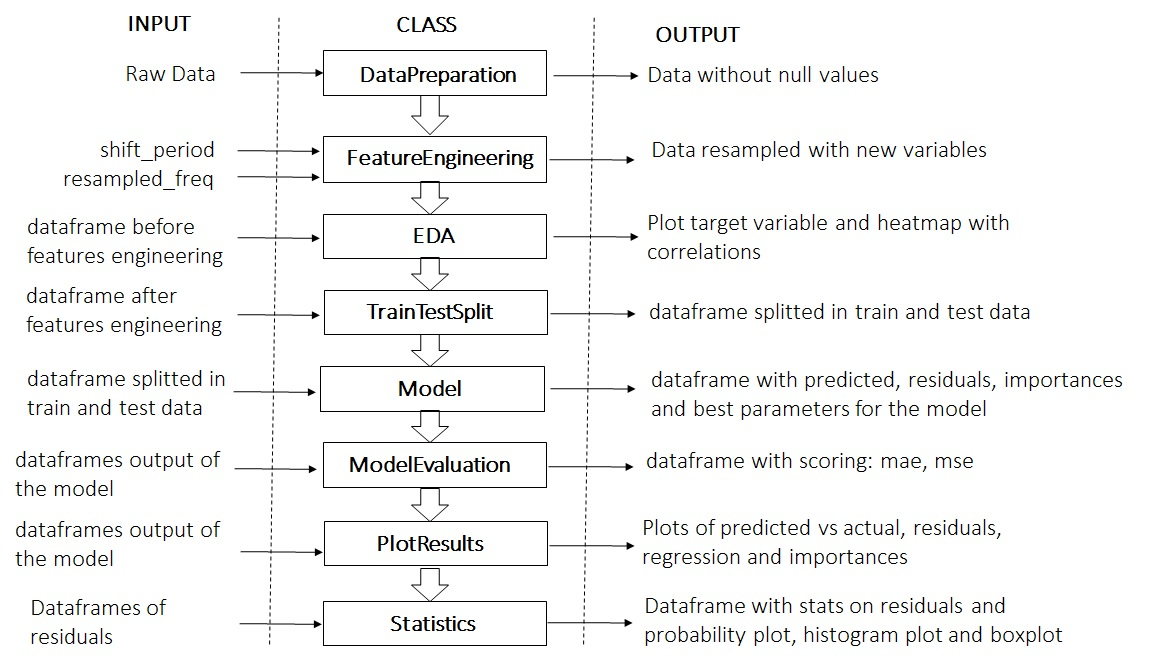

## Acquifers predictions

In [ ]:
resampled_freq = ['W','M','SM']
shift_period = [1,2,3]
combinations = list((itertools.product(shift_period,resampled_freq)))
data_input = {'Auser':[Acq_Auser,'Depth'], 'Doganella':[Acq_Doganella,'Depth'],'Luco':[Acq_Luco,'Depth'], 'Petrignano':[Acq_Petrignano,'Depth']}
output_model = {}
model_results = pd.DataFrame(columns = ['Data', 'Frequency', 'Shift period',  'Mean squared error', 'Mean absolute error','Best parameters'] )

### EDA Acquifers

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    EDA(df,'Depth',df_name = d).plot_target()
    

From the EDA analysis we can see that there is a correlation between Depth to groundwater and rainfall. Rainfall is an important variable in predicting depth to groundwater and we can build new variables based upon rainfall to increase the ability of our model to predict the target variable. Volume variables are others important variables for acquifers.

### Model Acquifers

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df , best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = model_results.append(ModelEvaluation(X_test, y_test,d,comb[1],comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0],best_params).score_model())
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Model results (models are ranked by Mean squared error and Mean absolute error)

In [ ]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])

Auser --> best model has a frequency SM and a shift period of 1 with a mse and a mae respectively of 0.205 and 0.324 m

Doganella --> best model has a frequency M and a shift period of 1 with a mse and a mae respectively of 15.60 and 2.77 m

Luco --> best model has a frequency W and a shift period of 1 with a mse and a mae respectively of 1.11 and 0.89 m


Petrignano --> best model has a frequency M and a shift period of 3 with a mse and a mae respectively of 5.21 and 2.05

### Plot results and statistics

****We can plot results for every waterbody and combination of resampled frequency and shift period****. 
Let's do it for Auser waterbody. Best model has a frequency of SM and a shift period of 1. Every output is in ouyput dictionary. So we need to search for key 'Auser_SM_1' and plot statistics about that model

In [ ]:
PlotResults(output_model['Auser_SM_1'][0], output_model['Auser_SM_1'][1],output_model['Auser_SM_1'][2],output_model['Auser_SM_1'][3]).plot_result()

Features importance

In [ ]:
PlotResults(output_model['Auser_SM_1'][0], output_model['Auser_SM_1'][1],output_model['Auser_SM_1'][2],output_model['Auser_SM_1'][3]).plot_importances(9,figure_width=12,figure_height =5)

Hydrometry Piaggione and Monte San Quirico are the most important variables. The first 9 variables account for more than 50% of importance.

In [ ]:
Statistics(output_model['Auser_SM_1'][2]).statistics()

In [ ]:
Statistics(output_model['Auser_SM_1'][2]).plot_stat()

## Water Spring predictions

In [ ]:
resampled_freq = ['W','M','SM']
shift_period = [1,2,3]
combinations = list((itertools.product(shift_period,resampled_freq)))
data_input = {'Amiata':[Ws_Amiata,'Flow'], 'Lupa':[Ws_Lupa,'Flow'],'Madonna_di_canneto':[Ws_Madonna_di_Canneto,'Flow']}
output_model = {}
model_results = pd.DataFrame(columns = ['Data', 'Frequency', 'Shift period',  'Mean squared error', 'Mean absolute error','Best parameters'] )

### EDA Water Spring

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    EDA(df,'Flow',df_name = d).plot_target()
    

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df , best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = model_results.append(ModelEvaluation(X_test, y_test,d,comb[1],comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0],best_params).score_model())
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Model results (models are ranked by Mean squared error and Mean absolute error)

In [ ]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])

Amiata --> best model has a frequency W and a shift period of 1 with a mse and a mae respectively of 0.69 and 0.65

Lupa --> best model has a frequency W and a shift period of 3 with a mse and a mae respectively of 75.5 and 6.2

Madonna di Canneto --> best model has a frequency W and a shift period of 2 with a mse and a mae respectively of 677 and 18

### Plot results and statistics

****We can plot results for every waterbody and combination of resampled frequency and shift period****. 
Let's do it for Amiata waterbody. Best model has a frequency of W and a shift period of 1. Every output is in ouyput dictionary. So we need to search for key 'Amiata_W_1' and plot statistics about that model

In [ ]:
PlotResults(output_model['Amiata_W_1'][0], output_model['Amiata_W_1'][1],output_model['Amiata_W_1'][2],output_model['Amiata_W_1'][3]).plot_result()

In [ ]:
PlotResults(output_model['Amiata_W_1'][0], output_model['Amiata_W_1'][1],output_model['Amiata_W_1'][2],output_model['Amiata_W_1'][3]).plot_importances(9,figure_width=12,figure_height =7)

In [ ]:
Statistics(output_model['Amiata_W_1'][2]).statistics()

In [ ]:
Statistics(output_model['Amiata_W_1'][2]).plot_stat()

## Arno river prediction

In [ ]:
resampled_freq = ['W','M','SM']
shift_period = [1,2,3]
combinations = list((itertools.product(shift_period,resampled_freq)))
data_input = {'Arno' : [River_Arno, 'Hydro'] }
output_model = {}
model_results = pd.DataFrame(columns = ['Data', 'Frequency', 'Shift period',  'Mean squared error', 'Mean absolute error','Best parameters'] )

### EDA Arno

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    EDA(df,'Hydro',df_name = d).plot_target()

For river Arno rainfall is important but there is also a correlation with temperature (in this dataset there is the temperature of Firenze).

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df , best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = model_results.append(ModelEvaluation(X_test, y_test,d,comb[1],comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0],best_params).score_model())
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Model results (models are ranked by Mean squared error and Mean absolute error)

In [ ]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])

Arno --> best model has a frequency M and a shift period of 1 with a mse and a mae respectively of 0.10 and 0.23

### Plot results and statistics

****We can plot results for every waterbody and combination of resampled frequency and shift period****. 
Let's do it for Arno waterbody. Best model has a frequency of M and a shift period of 1. Every output is in ouyput dictionary. So we need to search for key 'Arno_M_1' and plot statistics about that model

In [ ]:
PlotResults(output_model['Arno_M_1'][0], output_model['Arno_M_1'][1],output_model['Arno_M_1'][2],output_model['Arno_M_1'][3]).plot_result(figure_width=12,figure_height =7)

In [ ]:
PlotResults(output_model['Arno_M_1'][0], output_model['Arno_M_1'][1],output_model['Arno_M_1'][2],output_model['Arno_M_1'][3]).plot_importances(9,figure_width=12,figure_height =6)

In [ ]:
Statistics(output_model['Arno_M_1'][2]).statistics()

In [ ]:
Statistics(output_model['Arno_M_1'][2]).plot_stat(figure_width=12,figure_height =5)

## Lake bilancino flow rate predictions

In [ ]:
resampled_freq = ['W','M','SM']
shift_period = [1,2,3]
combinations = list((itertools.product(shift_period,resampled_freq)))
data_input = {'Lake_bilancino':[Lake_Bilancino,'Flow']}
output_model = {}
model_results = pd.DataFrame(columns = ['Data', 'Frequency', 'Shift period',  'Mean squared error', 'Mean absolute error','Best parameters'] )

### EDA Lake Bilancino Flow Rate

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    EDA(df,'Flow',df_name = d).plot_target()

Rainfall is the most important variables for lake Bilancino

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df , best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = model_results.append(ModelEvaluation(X_test, y_test,d,comb[1],comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0],best_params).score_model())
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Model results (models are ranked by Mean squared error and Mean absolute error)

In [ ]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])

Lake Bilancino (Flow rate prediction) --> best model has a frequency M and a shift period of 1 with a mse and a mae respectively of 4.62 and 1.49

### Plot results and statistics

****We can plot results for every waterbody and combination of resampled frequency and shift period****. 
Let's do it for Lake Bilancino waterbody. Best model has a frequency of M and a shift period of 1. Every output is in ouyput dictionary. So we need to search for key 'Lake_bilancino_M_1' and plot statistics about that model

In [ ]:
PlotResults(output_model['Lake_bilancino_M_1'][0], output_model['Lake_bilancino_M_1'][1],output_model['Lake_bilancino_M_1'][2],output_model['Lake_bilancino_M_1'][3]).plot_result(figure_width=12,figure_height =5)

In [ ]:
PlotResults(output_model['Lake_bilancino_M_1'][0], output_model['Lake_bilancino_M_1'][1],output_model['Lake_bilancino_M_1'][2],output_model['Lake_bilancino_M_1'][3]).plot_importances(9,figure_width=12,figure_height =5)

In [ ]:
Statistics(output_model['Lake_bilancino_M_1'][2]).statistics()

In [ ]:
Statistics(output_model['Lake_bilancino_M_1'][2]).plot_stat(figure_width=12,figure_height =5)

## Lake bilancino level predictions 

In [ ]:
resampled_freq = ['W','M','SM']
shift_period = [1,2,3]
combinations = list((itertools.product(shift_period,resampled_freq)))
data_input = {'Lake_bilancino':[Lake_Bilancino,'Lake']}
output_model = {}
model_results = pd.DataFrame(columns = ['Data', 'Frequency', 'Shift period',  'Mean squared error', 'Mean absolute error','Best parameters'] )

### EDA Lake Bilancino level

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    EDA(df,'Lake',df_name = d).plot_target()

In [ ]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df , best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = model_results.append(ModelEvaluation(X_test, y_test,d,comb[1],comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0],best_params).score_model())
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Model results (models are ranked by Mean squared error and Mean absolute error)

In [ ]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])

Lake Bilancino (lake level prediction) --> best model has a frequency W and a shift period of 1 with a mse and a mae respectively of 0.83 and 0.74

### Plot results and statistics

In [ ]:
PlotResults(output_model['Lake_bilancino_W_1'][0], output_model['Lake_bilancino_W_1'][1],output_model['Lake_bilancino_W_1'][2],output_model['Lake_bilancino_W_1'][3]).plot_result(figure_width=12,figure_height =5)

In [ ]:
PlotResults(output_model['Lake_bilancino_W_1'][0], output_model['Lake_bilancino_W_1'][1],output_model['Lake_bilancino_W_1'][2],output_model['Lake_bilancino_W_1'][3]).plot_importances(9,figure_width=12,figure_height =5)

In [ ]:
Statistics(output_model['Lake_bilancino_W_1'][2]).statistics()

In [ ]:
Statistics(output_model['Lake_bilancino_W_1'][2]).plot_stat(figure_width=12,figure_height =5)

## Conclusions

The model developed can give useful insights on how to predict water availabylity for a waterbody. It's developed to guarantee maximum flexibility of application to every waterbody.  Given the waterbody you want to predict you can adapt the model to the waterbody by just modify one or more classes. For example you can create new features only by modifying FeatureEngineering class. You can choose a different model rather than RandomForestRegressor only by modifying the model inside the pipe and the parameters inside RandomizedSearchCV. For model evaluation has been developed ModelEvaluation class in which mae and mse are calculated. For model evaluation it's also important to analyze residual plot using Statistics class. Data visualization is used for plotting importance variables (cumulated and not), for EDA in which is represented correlation between target variable and others features and for model evaluation and statistics. You can also see the results of every trained model using output_model dictionary. Model are ranked in model results dataframe which rank model by waterbody, mae and mse. An important point to note is that the resampled frequency and forecast period are input of the model. The best combination can be defined using a parameter like mae or mse. Every waterbody has an optimal combination of resampled frequency and forecast period and that are determined by the model. In conclusion the model developed  is easily extendable to other waterbodies just by modify one or more classes and can give useful insights on what are the features that most effect water availability. 

